In [2]:
from concurrent.futures import ProcessPoolExecutor
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from scipy import interpolate
from sklearn.base import BaseEstimator
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_array, check_is_fitted
from tqdm.auto import tqdm

from src import load_point_cloud
from src import show_point_cloud
from src import orient_normals
from src import rms_angle_error
from src.utils import apply_weight

# Input data

In [3]:
xyz, n = load_point_cloud('netsuke100k')

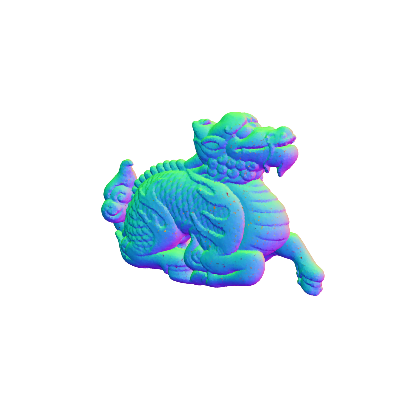

In [11]:
_, ax = show_point_cloud(xyz, n, elev=20, azim=-20);

In [5]:
class NormalEstimator(BaseEstimator):
    """Surface normal estimator.

    Parameters
    ----------
    k : float, optional
        The number of nearest neighbors of a local neighborhood around
        a current query point. Default is 30
    deg : str, optional
        Degree of the bivariate spline. Default is 3
    s : float, optional
        Positive smoothing factor for the bivariate spline
    kernel : str, optional
        The weighting function. By default, all weights are set to 1
    gamma : float, optional
        A scaling factor for the weighting function. If not given, it
        is set to 1
    """
    def __init__(self, k=30, deg=3, s=None, kernel=None, gamma=None):
        self.k = k
        self.deg = deg
        self.s = s
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y=None):
        """A reference implementation of a fitting function.

        Parameters
        ----------
        X : numpy.ndarray
            The input point cloud of shape (n_points, 3)
        y : None
            Ignored

        Returns
        -------
        self : object
            Fitted normal estimator
        """
        X = check_array(X, accept_sparse=True)
        # create a kd-tree for quick nearest-neighbor lookup
        tree = spatial.KDTree(X)
        self.n_estim = np.empty_like(X)
        # iterate over all points
        for i, p in enumerate(X):
            # local neighbourhood
            _, idx = tree.query([p], k=self.k, eps=0.1, workers=-1)
            nbhd = X[idx.flatten()]
            # change of basis
            nbhd_c = nbhd - nbhd.mean(axis=0)
            C = (nbhd_c.T @ nbhd_c) / (nbhd.shape[0] - 1)
            U, _, _ = np.linalg.svd(C)
            nbhd_t = nbhd_c @ U
            # add weights
            if self.kernel:
                w = apply_weight(p, nbhd, self.kernel, self.gamma)
            else:
                w = np.ones((nbhd.shape[0], ))
            # interpolate
            h = interpolate.SmoothBivariateSpline(*nbhd_t.T,
                                                  w=w,
                                                  kx=self.deg,
                                                  ky=self.deg,
                                                  s=self.s)
            # compute normals as partial derivatives of the "height" function
            ni = np.array([-h(*nbhd_t[0, :2], dx=1).item(),
                           -h(*nbhd_t[0, :2], dy=1).item(),
                           1])
            # convert normal coordinates into the original coordinate frame
            ni = U @ ni
            # normalization
            self.n_estim[i, :] = ni / np.linalg.norm(ni)
        self.is_fitted_ = True
        return self

    def predict(self, X=None):
        """Return estimated normals.

        Parameters
        ----------
        X : None
            Ignored

        Returns
        -------
        y : numpy.ndarray
            Estimated surface normals of shape (n_points, 3)
        """
        check_is_fitted(self, 'is_fitted_')
        return self.n_estim

In [6]:
estimator = NormalEstimator()
estimator = estimator.fit(xyz)

In [7]:
def scorer(y, y_pred):
    return rms_angle_error(y_pred, y, orient=False)

In [8]:
custom_scorer = make_scorer(scorer, greater_is_better=False)

In [9]:
parameters = {'k': [30, 50, 100],
              'kernel': [None, 'rbf']}
est = NormalEstimator()
cv = [(slice(None), slice(None))]
grid = GridSearchCV(est, parameters,
                    cv=cv,
                    scoring=custom_scorer,
                    n_jobs=-1
                   )
grid.fit(xyz, n)

GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=NormalEstimator(), n_jobs=-1,
             param_grid={'k': [30, 50, 100], 'kernel': [None, 'rbf']},
             scoring=make_scorer(scorer, greater_is_better=False))

In [10]:
import pandas as pd
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_k,param_kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,28.613715,0.0,0.006136,0.0,30,None,"{'k': 30, 'kernel': None}",-6.979162,-6.979162,0.0,2
1,21.417199,0.0,0.006345,0.0,30,rbf,"{'k': 30, 'kernel': 'rbf'}",-6.735568,-6.735568,0.0,1
2,29.812495,0.0,0.005471,0.0,50,None,"{'k': 50, 'kernel': None}",-8.497686,-8.497686,0.0,4
3,24.136140,0.0,0.006442,0.0,50,rbf,"{'k': 50, 'kernel': 'rbf'}",-7.851780,-7.851780,0.0,3
4,34.230187,0.0,0.004832,0.0,100,None,"{'k': 100, 'kernel': None}",-11.340180,-11.340180,0.0,6
5,35.999950,0.0,0.004103,0.0,100,rbf,"{'k': 100, 'kernel': 'rbf'}",-9.672523,-9.672523,0.0,5
